# Student Performance

## Данные
Рассмотрим набор данных [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/student+performance): данные об успеваемости учащихся.

Имеется 2 набора данных: математика (395 студентов) и португальский язык (649 студентов), но первый почти полностью лежит во втором, поэтому будем рассматривать только данные об изучающих португальский язык.

Для каждого студента имеется 30 признаков + 3 целевых признака (G1, G2, G3) - оценка по курсу (за первую часть курса, за вторую часть курса и итоговая).

## Задание
Нужно решить задачу предсказания целевого признака G3 итоговой оценки студента по курсу. G3 сильно коррелирует с G1 и G2, поэтому пользоваться этими признаками нельзя. Для оценки качества моделей использовать кросс-валидацию с 10 фолдами, функция потерь - Mean Absolute Error $L(y_{true}, y_{pred}) = \frac{1}{l}\sum_{i=1}^l |y_{true, i} - y_{pred, i}|$. Ваша задача - получить наименьшую ошибку на кросс-валидации, для этого поэкспериментируйте с разными моделями машинного обучения и разными признаковыми описаними объектов. Результаты оформите в виде Jupyter Notebook. Весь код должен без проблем запускаться и отрабатывать. Также оформите некоторые выводы (какие методы Вы использовали, что получилось, какой метод лучший).

Замечения:
1. Для загрузки данных можно использовать pandas, для машинного обучения - sklearn.
2. Для кросс-валидации можно использовать модуль sklearn.model_selection. Для воспроизводимости результатов явно инициализируйте генератор случайных чисел (разберитесь, как).
3. Обратите внимание, что многие признаки в наборе данных - не вещественные, а категориальные (categorical) или порядковые (ordinal). О том, как работать с такими признаками, можно начать читать [здесь](https://dyakonov.org/2016/08/03/python-%d0%ba%d0%b0%d1%82%d0%b5%d0%b3%d0%be%d1%80%d0%b8%d0%b0%d0%bb%d1%8c%d0%bd%d1%8b%d0%b5-%d0%bf%d1%80%d0%b8%d0%b7%d0%bd%d0%b0%d0%ba%d0%b8/).
4. Обратите внимание, что целевой признак - целые числа от 0 до 20.
5. Обратите внимание, что не все алгоритмы обучения способны работать с L1-loss. Но не факт, что их нужно обучать с L1-loss.

In [172]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import LabelEncoder
from IPython.core.pylabtools import figsize
from sklearn import tree
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'catboost'

In [60]:
df = pd.read_csv('student-por.csv', sep=';')

In [61]:
df = df.drop(['G1', 'G2'], axis=1)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 31 columns):
school        649 non-null object
sex           649 non-null object
age           649 non-null int64
address       649 non-null object
famsize       649 non-null object
Pstatus       649 non-null object
Medu          649 non-null int64
Fedu          649 non-null int64
Mjob          649 non-null object
Fjob          649 non-null object
reason        649 non-null object
guardian      649 non-null object
traveltime    649 non-null int64
studytime     649 non-null int64
failures      649 non-null int64
schoolsup     649 non-null object
famsup        649 non-null object
paid          649 non-null object
activities    649 non-null object
nursery       649 non-null object
higher        649 non-null object
internet      649 non-null object
romantic      649 non-null object
famrel        649 non-null int64
freetime      649 non-null int64
goout         649 non-null int64
Dalc          649 no

In [63]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000


In [64]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [65]:
missing_values_table(df)

Your selected dataframe has 31 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


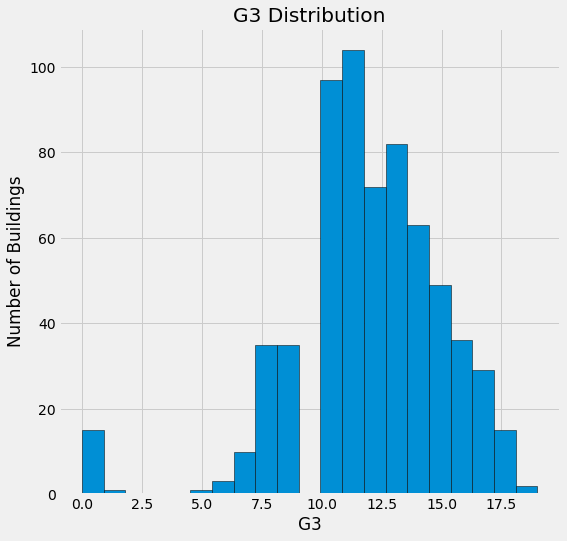

In [66]:

import matplotlib.pyplot as plt
figsize(8, 8)
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(df['G3'].dropna(), bins = 21, edgecolor = 'k');
plt.xlabel('G3'); plt.ylabel('Number of Buildings');
plt.title('G3 Distribution');

In [67]:
correlations_df = df.corr()['G3'].sort_values()
print(correlations_df.head(15), '\n')
print(correlations_df.tail(15))

failures     -0.393316
Dalc         -0.204719
Walc         -0.176619
traveltime   -0.127173
freetime     -0.122705
age          -0.106505
health       -0.098851
absences     -0.091379
goout        -0.087641
famrel        0.063361
Fedu          0.211800
Medu          0.240151
studytime     0.249789
G3            1.000000
Name: G3, dtype: float64 

failures     -0.393316
Dalc         -0.204719
Walc         -0.176619
traveltime   -0.127173
freetime     -0.122705
age          -0.106505
health       -0.098851
absences     -0.091379
goout        -0.087641
famrel        0.063361
Fedu          0.211800
Medu          0.240151
studytime     0.249789
G3            1.000000
Name: G3, dtype: float64


In [76]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['G3']
    x = x.drop(columns = ['G3'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the score back in to the data
    x['G3'] = y
               
    return x

In [77]:
features = df.copy()
numeric_subset = df.select_dtypes('number')
for c in numeric_subset.columns:
    if c == 'G3':
        next
    else:
        numeric_subset['log_' + c] = np.log(numeric_subset[c])
categorical_subset = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'school', 'sex',\
                            'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', \
                            'guardian', 'schoolsup', 'famsup', 'paid', 'activities', \
                            'nursery', 'higher', 'internet', 'romantic']]
categorical_subset = pd.get_dummies(categorical_subset)
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
features.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


(649, 74)

In [78]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 74 columns):
age                  649 non-null int64
Medu                 649 non-null int64
Fedu                 649 non-null int64
traveltime           649 non-null int64
studytime            649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
G3                   649 non-null int64
log_age              649 non-null float64
log_Medu             649 non-null float64
log_Fedu             649 non-null float64
log_traveltime       649 non-null float64
log_studytime        649 non-null float64
log_failures         649 non-null float64
log_famrel           649 non-null float64
log_freetime         649 non-null float64

In [79]:
features = remove_collinear_features(features, 0.6);


In [80]:
features  = features.dropna(axis=1, how = 'all')
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 53 columns):
age                  649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
school_GP            649 non-null uint8
school_MS            649 non-null uint8
sex_F                649 non-null uint8
sex_M                649 non-null uint8
address_R            649 non-null uint8
address_U            649 non-null uint8
famsize_GT3          649 non-null uint8
famsize_LE3          649 non-null uint8
Pstatus_A            649 non-null uint8
Pstatus_T            649 non-null uint8
Mjob_at_home         649 non-null uint8
Mjob_health          649 non-null uint8
Mjob_other           649 non-null uint8
Mjob_services  

In [81]:
correlations_features = features.corr()['G3'].sort_values()
print(correlations_features.head(15), '\n')
print(correlations_features.tail(15))

failures        -0.393316
higher_no       -0.332172
school_MS       -0.284294
Dalc            -0.204719
Walc            -0.176619
address_R       -0.167637
internet_no     -0.150025
Mjob_at_home    -0.136778
reason_other    -0.132577
sex_M           -0.129077
freetime        -0.122705
age             -0.106505
health          -0.098851
reason_course   -0.098305
absences        -0.091379
Name: G3, dtype: float64 

famsup_yes           0.059206
activities_yes       0.059791
famrel               0.063361
schoolsup_no         0.066405
romantic_no          0.090583
Mjob_health          0.101244
Fjob_teacher         0.125916
sex_F                0.129077
Mjob_teacher         0.134910
internet_yes         0.150025
address_U            0.167637
reason_reputation    0.170944
school_GP            0.284294
higher_yes           0.332172
G3                   1.000000
Name: G3, dtype: float64


In [82]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 53 columns):
age                  649 non-null int64
failures             649 non-null int64
famrel               649 non-null int64
freetime             649 non-null int64
goout                649 non-null int64
Dalc                 649 non-null int64
Walc                 649 non-null int64
health               649 non-null int64
absences             649 non-null int64
school_GP            649 non-null uint8
school_MS            649 non-null uint8
sex_F                649 non-null uint8
sex_M                649 non-null uint8
address_R            649 non-null uint8
address_U            649 non-null uint8
famsize_GT3          649 non-null uint8
famsize_LE3          649 non-null uint8
Pstatus_A            649 non-null uint8
Pstatus_T            649 non-null uint8
Mjob_at_home         649 non-null uint8
Mjob_health          649 non-null uint8
Mjob_other           649 non-null uint8
Mjob_services  

In [94]:
cat = ['Medu', 'Fedu', 'traveltime', 'studytime', 'school', 'sex',\
                            'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', \
                            'guardian', 'schoolsup', 'famsup', 'paid', 'activities', \
                            'nursery', 'higher', 'internet', 'romantic']

In [96]:
X = features.drop(['G3'], axis=1)

In [97]:
Y = features['G3']

In [170]:
models = [[Ridge(random_state=123890), 0],
          [SGDRegressor(loss='huber', random_state=123890), 0],
          [Lasso(random_state=123890), 0],
          [ElasticNet(random_state=123890), 0],
          [tree.DecisionTreeRegressor(random_state=123890, criterion='mae'), 1],
          [SVR(), 2],
          [KNeighborsRegressor(metric='manhattan'), 3]]

scorer = make_scorer(mean_absolute_error)
res = {model[0].__class__.__name__: [] for model in models}
p_g = [{'alpha': np.arange(0.001, 1.001, 0.001)},
       {'max_depth':np.arange(1, 6)},
       {'kernel': ['rbf', 'linear', 'poly'], 'C': np.arange(1, 100)},
       {'n_neighbors':np.arange(1, 10)}
      ]

In [171]:
res = {model.__class__.__name__: 0 for model in models}
for model in models:
    gr = GridSearchCV(estimator=model[0], param_grid=p_g[model[1]],
                  n_jobs=-1, verbose=1, cv=10, scoring=scorer, return_train_score=True
             )
    gr.fit(X, Y)
    res[model.__class__.__name__] = [gr.best_score_, gr.best_params_]
    print(res)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2480 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 6480 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   36.9s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'list': [2.0480740836447655, {'alpha': 0.001}]}
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 7820 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   42.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 c

{'list': [2.838703648230505, {'alpha': 1.0}]}
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 7820 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   33.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'list': [2.4410837209323923, {'alpha': 1.0}]}
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4348 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   41.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'list': [2.3677918152769357, {'alpha': 1.0}]}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'list': [2.2704160246533127, {'max_depth': 1}]}
Fitting 10 folds for each of 297 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 1846 tasks      | elapsed: 55.5min
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed: 91.9min
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed: 120.3min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled fea

{'list': [3.927385806491669, {'C': 99, 'kernel': 'poly'}]}
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    1.6s


{'list': [2.987673343605547, {'n_neighbors': 1}]}


[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [173]:
lr = CatBoostRegressor(loss_function='MAE')

NameError: name 'CatBoostRegressor' is not defined

In [131]:
gr = GridSearchCV(estimator=lr, param_grid={'alpha': np.arange(0.001, 1.001, 0.01)},\
                  n_jobs=-1, verbose=1, cv=10, scoring=scorer,\
                 return_train_score=True)

In [132]:
gr.fit(X, Y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123890, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([0.001, 0.011, ..., 0.981, 0.991])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_absolute_error), verbose=1)

In [139]:
pd.DataFrame(gr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004808,0.000708,0.001653,0.000337,0.001,{'alpha': 0.001},1.435532,1.596441,1.833912,1.886301,...,1.923662,1.893111,1.932538,1.884239,1.875665,1.890698,1.855118,1.687341,1.882834,0.071135
1,0.008728,0.004812,0.002110,0.001199,0.011,{'alpha': 0.011},1.435513,1.596463,1.833873,1.886279,...,1.923662,1.893110,1.932532,1.884235,1.875662,1.890694,1.855118,1.687337,1.882832,0.071135
2,0.009925,0.005437,0.001702,0.000286,0.021,{'alpha': 0.020999999999999998},1.435493,1.596485,1.833834,1.886256,...,1.923662,1.893109,1.932527,1.884232,1.875660,1.890691,1.855118,1.687333,1.882829,0.071135
3,0.009585,0.006721,0.002231,0.001593,0.031,{'alpha': 0.030999999999999996},1.435474,1.596506,1.833795,1.886233,...,1.923663,1.893108,1.932521,1.884228,1.875657,1.890687,1.855117,1.687329,1.882826,0.071136
4,0.006710,0.003723,0.001713,0.000313,0.041,{'alpha': 0.040999999999999995},1.435455,1.596527,1.833756,1.886210,...,1.923663,1.893107,1.932516,1.884224,1.875654,1.890683,1.855117,1.687324,1.882824,0.071136
5,0.006998,0.004127,0.002701,0.002286,0.051,{'alpha': 0.05099999999999999},1.435436,1.596549,1.833717,1.886187,...,1.923664,1.893106,1.932511,1.884221,1.875651,1.890679,1.855117,1.687320,1.882821,0.071136
6,0.009639,0.007851,0.001777,0.000544,0.061,{'alpha': 0.06099999999999999},1.435417,1.596570,1.833678,1.886164,...,1.923664,1.893106,1.932505,1.884217,1.875648,1.890675,1.855117,1.687316,1.882818,0.071137
7,0.007304,0.003465,0.001975,0.001084,0.071,{'alpha': 0.071},1.435398,1.596592,1.833639,1.886141,...,1.923665,1.893105,1.932500,1.884213,1.875645,1.890671,1.855116,1.687311,1.882816,0.071137
8,0.008036,0.004077,0.001587,0.000197,0.081,{'alpha': 0.08099999999999999},1.435379,1.596613,1.833601,1.886118,...,1.923665,1.893104,1.932495,1.884210,1.875642,1.890668,1.855116,1.687307,1.882813,0.071137
9,0.004861,0.000381,0.003413,0.003330,0.091,{'alpha': 0.09099999999999998},1.435360,1.596635,1.833562,1.886096,...,1.923666,1.893103,1.932489,1.884206,1.875639,1.890664,1.855116,1.687303,1.882811,0.071138


In [143]:
gr.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123890, solver='auto', tol=0.001)

In [141]:
gr.best_index_

0

In [58]:
df3 = pd.DataFrame(gr.cv_results_)

In [64]:
df3['mean_test_score'].T

0    -2.067863
1    -2.067664
2    -2.067465
3    -2.067268
4    -2.067073
5    -2.066879
6    -2.066687
7    -2.066496
8    -2.066307
9    -2.066119
10   -2.065931
11   -2.065746
12   -2.065561
13   -2.065377
14   -2.065195
15   -2.065014
16   -2.064833
17   -2.064654
18   -2.064476
19   -2.064299
Name: mean_test_score, dtype: float64

In [ ]:
models = [lass
elasticnet
boosting
randomforest

In [ ]:
log = {model.__class__.__name__:0 for model in models}

In [22]:
df2 = pd.get_dummies(df, columns=['Medu', 'Fedu', 'traveltime', 'studytime', 'school', 'sex',\
                            'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', \
                            'guardian', 'schoolsup', 'famsup', 'paid', 'activities', \
                            'nursery', 'higher', 'internet', 'romantic'])